# Importing Modules

In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.constants import mu_0
from scipy.constants import physical_constants
import matplotlib
import matplotlib.pyplot as plt

import data_tests_functions as dtf

matplotlib.rcParams.update({'font.size': 14})

print('Importing done.')

Importing done.


In [2]:
def round_to_significant_digits(value, sig_digits):
    """
    Rounds a value to a specified number of significant digits.
    :param value: The value to round.
    :param sig_digits: The number of significant digits to round to.
    :return: The rounded value.
    """
    if value == 0:
        raise ValueError("Cannot round a value of 0 to significant digits.")
    digits = -int(np.floor(np.log10(abs(value))) - (sig_digits - 1))
    value_rounded = round(value, digits)
    return value_rounded

# Data directory input

In [3]:
# data_dir = '/Users/santapile/Santas/Projects/MaMMoS/NOMAD/dataExamples/UU/UU-sets/Fe3-xZnxY(x=0.22)'

# data_dir = 'Co2Fe2H4'
# data_dir = 'Co2Fe16Y6'
# data_dir = 'Fe3-xTaxY(x=0.22)'
# data_dir = 'Fe3-xVxY(x=0.22)'
data_dir = '/Users/santapile/Santas/DataAnalysis/nomad/data_preview/dataSets/Mn2CrB4'

In [4]:
import check_file_and_folder_structure as cffs
cffs.check_structure(data_dir, check_README=True, verbose=True)

False

In [5]:
data_dir_GS = data_dir + "/GS"
data_dir_MC = data_dir + "/MC"

xyz_dirs = [dirdir for dirdir in os.listdir(data_dir_GS) if len(dirdir) == 1]

print(data_dir_GS)
print(data_dir_MC)
print(xyz_dirs)

/Users/santapile/Santas/DataAnalysis/nomad/data_preview/dataSets/Mn2CrB4/GS
/Users/santapile/Santas/DataAnalysis/nomad/data_preview/dataSets/Mn2CrB4/MC
['z', 'x']


# Magnetization

In [6]:
# Reading file into lines; all folders are equivalent according to UU-colleagues, so we can use the first one
file_Name_Ms = data_dir_GS + f"/{xyz_dirs[0]}/out_last"
print(file_Name_Ms)

# Create dicts with orbital IDs and values of corresponding
# Total moment and its direction (+/-1)
tot_moments_D = dtf.find_line_val_dict(file_Name_Ms, 'Total moment [J=L+S] (mu_B):')
dir_of_JD = dtf.find_line_val_dict(file_Name_Ms, 'Direction of J (Cartesian):')
# print("tot_moments_D:"+str(tot_moments_D))
# print("dir_of_JD:"+str(dir_of_JD))
params_merged = {}
for key in tot_moments_D.keys():
    params_merged[key] = tot_moments_D[key] + dir_of_JD[key]

# Pretty table for checking the entries for magnetic moments and directions
df = pd.DataFrame.from_dict(params_merged, orient='index',
                            columns = ['J=L+S (Cartesian)',
                                       'J=L+S (Spin axis)',
                                       'Direction of J (x)',
                                       'Direction of J (y)',
                                       'Direction of J (z)'])
df

/Users/santapile/Santas/DataAnalysis/nomad/data_preview/dataSets/Mn2CrB4/GS/z/out_last


,J=L+S (Cartesian),J=L+S (Spin axis),Direction of J (x),Direction of J (y),Direction of J (z)
ID:0102010100-o,0.169102,0.169102,-6.206000e-05,4.468000e-05,-1.0
ID:0101010100-o,0.001876,0.001876,3.050000e-05,2.949000e-05,-1.0
ID:0100010100-o,0.002109,0.002109,3.170000e-06,1.250000e-06,-1.0
ID:0201010100-o,0.036835,0.036835,-1.479000e-05,1.017000e-05,-1.0
ID:0200010100-o,0.010785,0.010785,4.420000e-06,-5.770000e-06,-1.0
ID:0301010100-o,0.036835,0.036835,-1.163000e-05,1.030000e-05,-1.0
ID:0300010100-o,0.010785,0.010785,4.480000e-06,-5.790000e-06,-1.0
ID:0401010100-o,0.010832,0.010832,-1.418000e-05,1.245000e-05,-1.0
ID:0400010100-o,0.004412,0.004412,6.440000e-06,6.160000e-06,-1.0
ID:0501010100-o,0.010832,0.010832,-1.897000e-05,7.780000e-06,-1.0


## Calculating magnetization
**Use:** Cartesian (with direction) - we should use that</br>
Spin axis coordinates we ignore

In [7]:
# Calculating total magnetic moment by summing all
# (Total moment (of an orbital) * Direction of J (takes the one with abs value > 0.9, should be +/-1))
tot_magn_mom_C = 0
for key in tot_moments_D.keys():
    tot_magn_mom_C += tot_moments_D[key][0]*[x for x in dir_of_JD[key] if abs(x) > 0.9][0]
    print(key, ': ', tot_moments_D[key][0], '*', 
          [x for x in dir_of_JD[key] if abs(x) > 0.9][0], '=', 
          tot_moments_D[key][0]*[x for x in dir_of_JD[key] if abs(x) > 0.9][0])
    #    total magnetic moment J=L+S * orientation, wherever +/-1 is

print(f'\nTotal magnetic moment = {tot_magn_mom_C}')

# Getting unit cell volume in A^3 from the file
ucv = dtf.find_line_val_dict(file_Name_Ms, 'unit cell volume:')
print(ucv)
# Recalculating in=t in angstroms (should be transferred to m afterwards)
ucvA = ucv[list(ucv.keys())[0]][0] / 1.8897259**3 # unit cell volume in A
print(f'Unit cell volume: {ucvA} A\N{SUPERSCRIPT THREE}')

# Calculating magnetization in Tesla
magnetization_in_T = tot_magn_mom_C/ucvA*11.654
print(f'Magnetization Ms: {magnetization_in_T} T')

ID:0102010100-o :  0.1691017 * -1.0 = -0.1691017
ID:0101010100-o :  0.001876488 * -1.0 = -0.001876488
ID:0100010100-o :  0.002109031 * -1.0 = -0.002109031
ID:0201010100-o :  0.03683499 * -1.0 = -0.03683499
ID:0200010100-o :  0.01078508 * -1.0 = -0.01078508
ID:0301010100-o :  0.03683512 * -1.0 = -0.03683512
ID:0300010100-o :  0.01078509 * -1.0 = -0.01078509
ID:0401010100-o :  0.01083202 * -1.0 = -0.01083202
ID:0400010100-o :  0.004412454 * -1.0 = -0.004412454
ID:0501010100-o :  0.01083193 * -1.0 = -0.01083193
ID:0500010100-o :  0.004412453 * -1.0 = -0.004412453
ID:0602010100-o :  1.774867 * 1.0 = 1.774867
ID:0601010100-o :  0.00508757 * 1.0 = 0.00508757
ID:0600010100-o :  0.005818217 * 1.0 = 0.005818217
ID:0702010100-o :  1.774867 * 1.0 = 1.774867
ID:0701010100-o :  0.005087558 * 1.0 = 0.005087558
ID:0700010100-o :  0.005818218 * 1.0 = 0.005818218

Total magnetic moment = 3.272729207
{'unit': [378.016829224733]}
Unit cell volume: 56.01633474574038 A³
Magnetization Ms: 0.6808797175234369

### Q&A
**Question #1:** Why doubled data for each orbital? </br>
<b>Answer #1:</b> because calculations may run several times, that's why we need to take the last one

**Question #2:** How do we calculate total magnetic moment? (Does direction matter?) </br>
<b>Answer #2:</b> the direction does matter. For testing approximate resulting value of Ms should be in the README file, our result should be in 2% range of it

# Anisotropy

In [8]:
energies = {}

if f'out_MF_{xyz_dirs[0]}' in os.listdir(data_dir_GS+f'/{xyz_dirs[0]}'):
    for dirdir in xyz_dirs:
        fileName = data_dir_GS+f"/{dirdir}/out_MF_{dirdir}"
        eigenvalue_sum = dtf.find_line_val_dict(fileName, 'Eigenvalue sum:')
        energies[dirdir] = eigenvalue_sum[list(eigenvalue_sum.keys())[0]][0]
elif f'out_Etot_{xyz_dirs[0]}' in os.listdir(data_dir_GS+f'/{xyz_dirs[0]}'):
    for dirdir in xyz_dirs:
        fileName = data_dir_GS+f"/{dirdir}/out_Etot_{dirdir}"
        energies[dirdir] = dtf.get_energy_from_file(fileName)
else:
    print('no files for anisotropy')

allKs = list()
if 'z' in energies.keys():
    if 'x' in energies.keys():
        Kxz = (energies['x'] - energies['z'])/ucvA*2179874
        allKs.append(Kxz)
    if 'y' in energies.keys():    
        Kyz = (energies['y'] - energies['z'])/ucvA*2179874
        allKs.append(Kyz)

K1_in_JPerCubibm = max(allKs) * 1e6            # anisotropy J/m³; MagnetocrystallineAnisotropyConstantK1

print(f'Anisotropy constant (max of all): {K1_in_JPerCubibm} J/m\N{SUPERSCRIPT THREE}')

Anisotropy constant (max of all): 752394.1104370862 J/m³


# Exchange

[  2.   5.  10.  50. 100. 150. 200. 250. 300. 400. 500. 600. 700. 800.
 900.]
Number of atoms: 7
Number of atoms: 7
Tc = 900.0 K
0.7282412876371519 1.6684819346488076
Spin wave stiffness constant  2.794921487119052e-40
Exchange constant A at T=0 (J/m) :  4.366238873275821e-12
Js_300 (T) : 0.6532473279004221
A_300 (J/m) : 3.513275284753546e-12
K_300 (MJ/m^3) : 0.5430657582908239
Lex  3.2164987008037094


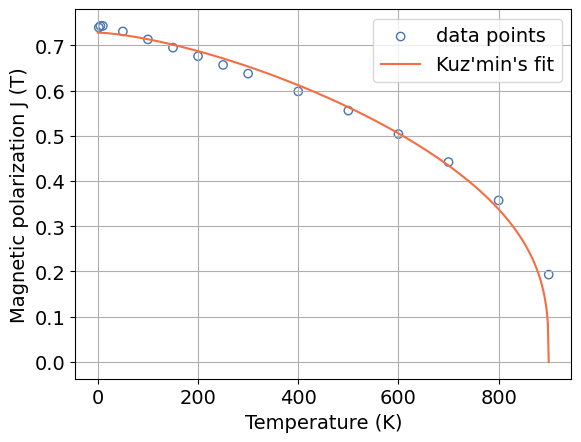

In [9]:
# Define the form of the function you want to fit
fn = data_dir_MC + '/M(T)'  # magnetic polarization
TK, Js = dtf.read_2_col_data(fn)
print(TK)

mc_dirs = [dirdir for dirdir in os.listdir(data_dir_MC) if dirdir in ['momfile', 'posfile']]

if len(mc_dirs) > 0:
    with open(data_dir_MC + '/' + mc_dirs[0], 'rt') as f:
        n_atoms = len(f.read().splitlines())
    print(f'Number of atoms: {n_atoms}')
else:
    print('There seem to be NO momfile and no posfile :( Getting n_atoms from GS/out_last')
    atoms_Ns = set([int(key[key.find(':')+1:key.find(':') + 3]) for key in tot_moments_D.keys()])
    n_atoms = len(atoms_Ns)
print(f'Number of atoms: {n_atoms}')
    
Js = [item*n_atoms/ucvA*11.654 for item in Js]

poscut = np.argmin(np.diff(Js)/np.diff(TK))+2
try:
    Tc = TK[poscut]
except IndexError:
    Tc = TK[-1]
    poscut = len(TK) - 1

print(f'Tc = {Tc} K')
TKc = TK[:poscut].copy()
Jsc = Js[:poscut].copy()

xfine = np.linspace(0, Tc, 500)
p    = 5.0 / 2
beta = 1. / 3
m_s = partial(dtf.spontaneous_magnetization, p=p, beta=beta, T_C=Tc)

popt, pcov = curve_fit(m_s, TKc, Jsc)
Js_0, s = popt
print(Js_0, s)
T_fit = np.linspace(min(TKc), max(TKc), 500)
Js_fit = m_s(T_fit, Js_0, s)

g = 2
k_b = physical_constants["Boltzmann constant"][0]
mu_b = physical_constants["Bohr magneton"][0]

M_0 = Js_0/mu_0
D = (0.1509
     * ((g * mu_b) / (s * beta * M_0)) ** (2. / 3)
     * k_b
     * Tc
     )
print("Spin wave stiffness constant ", D)
A_0 = M_0 * D / (2 * g * mu_b)
print("Exchange constant A at T=0 (J/m) : ", A_0)

# Magnetic polarization at 300 K
Js_300 = m_s(300., Js_0, s)
print("Js_300 (T) :", Js_300)

A_300 = A_0*(Js_300/Js_0)**2
print("A_300 (J/m) :", A_300)

K_300 = K1_in_JPerCubibm*(Js_300/Js_0)**3
print("K_300 (MJ/m^3) :", K_300/1e6)

# A = A_0*(Js/Js0)^2

# exchange length in nm; see eq. 96 in book chapter of Exl2016 etal. where for Ms = spontaneous magnetization since there is only one phase/material
print('Lex ', np.sqrt(mu_0*A_300/(Js_300*Js_300))/1e-9)

fig, ax = plt.subplots()
ax.scatter(TK, Js, marker="o", label="data points", facecolors='none', edgecolors='#4575b4')
label = "Kuz'min's fit"
ax.plot(xfine, m_s(xfine, Js_0, s), label=label, color='#f46d43')
ax.legend()
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetic polarization J (T)")
ax.grid()

### Data from README file for doublechecking

In [10]:
import re

# Ms - Ontology entry: SpontaneousMagneticPolarisation when given in T
# MAE - Ontology entry: MagnetocrystallineAnisotropyEnergy
with open(data_dir + '/README', 'rt') as f:
    print("### README:")
    print(f.read())
    print("### End of README\n")
    # Extract the value for Ms from README
    with open(data_dir + '/README', 'rt') as f:
        readme_content = f.read()

    ms_match = re.search(r'Ms\s*=\s*([\d.]+)\s*T', readme_content)
    if ms_match:
        Ms_README_in_T = float(ms_match.group(1))
        print(f"Extracted Ms value from README: {Ms_README_in_T} T")
    else:
        print("Ms value not found in README")

    mae_matches = re.findall(r'([xyz])\s*-\s*([xyz])\s*=\s*([-+]?\d*\.\d+|\d+)\s*MJ/m³', readme_content)
    if mae_matches:
        mae_values_in_MJPerCubicm = [float(match[2]) for match in mae_matches]
        max_MAE_README_in_MJPerCubicm = max(mae_values_in_MJPerCubicm)
        print(f"Extracted maximum MAE value from README: {max_MAE_README_in_MJPerCubicm} MJ/m³")
    else:
        mae_match = re.search(r'MAE\s*=\s*([\d.]+)\s*MJ/m³', readme_content)
        if mae_match:
            max_MAE_README_in_MJPerCubicm = float(mae_match.group(1))
            print(f"Extracted MAE value from README: {max_MAE_README_in_MJPerCubicm} MJ/m³")
        else:
            print("MAE values not found in README")

### README:
Ms = 0.70 T
MAE = 0.70 MJ/m3

### End of README

Extracted Ms value from README: 0.7 T
MAE values not found in README


### Summary of values computed from the dataset

#### Computation of anisotropy energy from the MagnetocrystallineAnisotropyConstantK1 
From Koys book, chapter 5.5.2, page171 anisotropy energy Ea = K1 sin2 θ + K2 sin4 θ where K2 is negelcted and θ≈0

In [11]:
MAE_in_MJPerCubicm = K1_in_JPerCubibm /1e6

In [12]:
Ms_in_T = magnetization_in_T    
# TODO: magnetization_in_T should be renamed polarisation_in_T or Js_in_T (SpontaneousMagneticPolarisation)

In [13]:
print(" Ms_in_T = "+str(round_to_significant_digits(Ms_in_T, 4)) + " T")
print(" MAE_in_MJPerCubicm = " + str(round_to_significant_digits(MAE_in_MJPerCubicm, 4)) + " MJ/m^3")

 Ms_in_T = 0.6809 T
 MAE_in_MJPerCubicm = 0.7524 MJ/m^3


### Computing deviations between computed values and given values from the README

In [14]:
deviation_Ms_in_percent = 100 - (Ms_in_T/ Ms_README_in_T) * 100
print(" Deviation for magnetization in percent = "+str(round_to_significant_digits(deviation_Ms_in_percent, 4)) + " %")

 Deviation for magnetization in percent = 2.731 %


In [15]:
try:
    deviation_mae_percent = 100 - ((MAE_in_MJPerCubicm) / max_MAE_README_in_MJPerCubicm) * 100
    print(" Deviation for anisotropy energy/constant in percent = " + str(round_to_significant_digits(deviation_mae_percent, 4)) + " %")
except NameError:
    print("MAE values not found in README")

MAE values not found in README


In [16]:
if (abs(deviation_Ms_in_percent)<2.) and (abs(deviation_mae_percent)<2.):
    print('The deviation for magnetization and anisotropy in dataset '+data_dir+' is\n **less** than 2% compared to the provided values.')
else:
    print('The deviation for magnetization and anisotropy in dataset '+data_dir+' is\n **more** than 2% compared to the provided values.')

The deviation for magnetization and anisotropy in dataset /Users/santapile/Santas/DataAnalysis/nomad/data_preview/dataSets/Mn2CrB4 is
 **more** than 2% compared to the provided values.
